<a href="https://colab.research.google.com/github/lauren1turner/DS4002_LAM/blob/project2/Timeseries_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Step 1: Load the CSV files into DataFrames
co_df = pd.read_csv('Daily_Avg_CO.csv')
ozone_df = pd.read_csv('Daily_Avg_Ozone.csv')
pm10_df = pd.read_csv('Daily_Avg_PM10.csv')
pm25_df = pd.read_csv('Daily_Avg_PM2.5.csv')

# Step 2: Convert 'Date' column to datetime (if it's not already in datetime format)
co_df['Date'] = pd.to_datetime(co_df['Date'])
ozone_df['Date'] = pd.to_datetime(ozone_df['Date'])
pm10_df['Date'] = pd.to_datetime(pm10_df['Date'])
pm25_df['Date'] = pd.to_datetime(pm25_df['Date'])

# Step 3: Merge all DataFrames on 'Date'
combined_df = co_df.merge(ozone_df, on='Date', how='outer')  # Outer join to keep all dates
combined_df = combined_df.merge(pm10_df, on='Date', how='outer')
combined_df = combined_df.merge(pm25_df, on='Date', how='outer')

# Step 4: Optionally, sort by 'Date'
combined_df = combined_df.sort_values(by='Date')

# Step 5: Save the combined DataFrame to a new CSV file
combined_df.to_csv('Combined_Daily_Avg_Climate_Data.csv', index=False)

# Display the first few rows of the combined DataFrame
print(combined_df.head())

        Date  Daily Max 8-hour CO Concentration  \
0 2022-01-01                           0.542857   
1 2022-01-02                           0.621429   
2 2022-01-03                           0.728571   
3 2022-01-04                           0.842857   
4 2022-01-05                           1.028571   

   Daily Max 8-hour Ozone Concentration  Daily Mean PM10 Concentration  \
0                              0.037067                      21.166667   
1                              0.036312                      14.833333   
2                              0.029437                      25.400000   
3                              0.027187                      28.800000   
4                              0.024375                      34.000000   

   Daily Mean PM2.5 Concentration  
0                       17.081250  
1                        7.857143  
2                       11.275000  
3                       15.300000  
4                       20.616000  


ADF Statistic for Daily Max 8-hour CO Concentration: -3.0620691724393834
p-value for Daily Max 8-hour CO Concentration: 0.029490582535519096
---
ADF Statistic for Daily Max 8-hour Ozone Concentration: -2.437770116188462
p-value for Daily Max 8-hour Ozone Concentration: 0.13135853880678933
---
ADF Statistic for Daily Mean PM10 Concentration: -5.238251705811174
p-value for Daily Mean PM10 Concentration: 7.341382376716513e-06
---
ADF Statistic for Daily Mean PM2.5 Concentration: -12.52227670895124
p-value for Daily Mean PM2.5 Concentration: 2.532978984845515e-23
---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


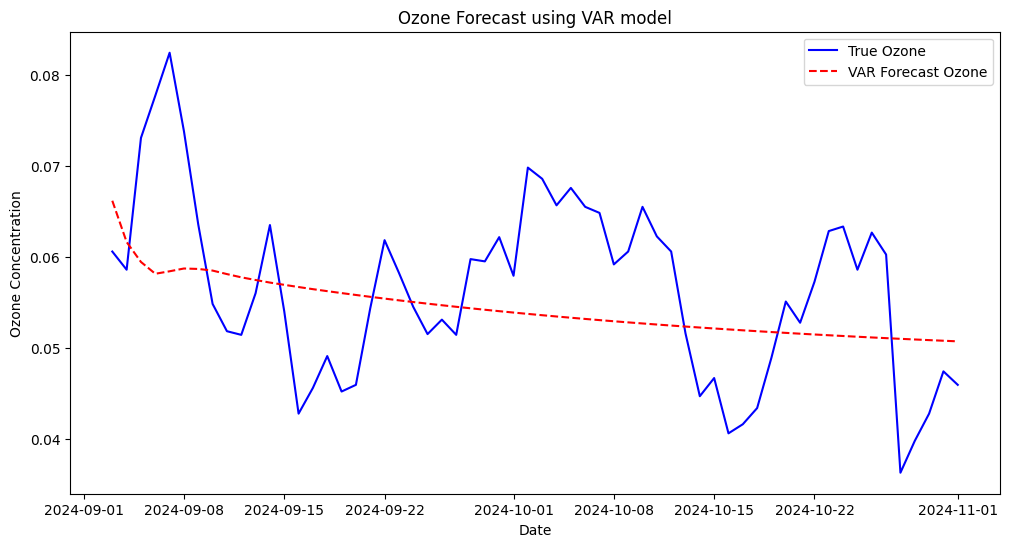

VAR Model - MAE: 0.008086008555212408, RMSE: 0.009462731892216383


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

# Step 1: Load the Data
df = pd.read_csv('Combined_Daily_Avg_Climate_Data.csv')  # Replace with your file path

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Step 2: Focus on the relevant columns for the VAR model
# Use the columns you provided: CO, Ozone, PM10, PM2.5
data = df[['Daily Max 8-hour CO Concentration',
           'Daily Max 8-hour Ozone Concentration',
           'Daily Mean PM10 Concentration',
           'Daily Mean PM2.5 Concentration']]

# Step 3: Handle missing data - you can either drop or fill
# Option 1: Drop rows with missing values
data = data.dropna()

# Option 2: Fill missing values (e.g., forward fill)
# data = data.fillna(method='ffill')

# Option 3: Fill missing values using interpolation (linear)
# data = data.interpolate(method='linear')

# Step 4: Check for stationarity (ADF test for each column)
for column in data.columns:
    result = adfuller(data[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    print('---')

# If p-value > 0.05, you need to difference the data to make it stationary
# For simplicity, let's assume the data is stationary, and we proceed.

# Step 5: Train-Test Split (using last 2 months as test data)
train_data = data[:-60]  # 60 days for testing (about 2 months)
test_data = data[-60:]

# Step 6: Fit the VAR model
model = VAR(train_data)
model_fitted = model.fit(5)  # Use a lag of 5, you can experiment with different lags

# Step 7: Make predictions on the test data
forecast = model_fitted.forecast(train_data.values[-5:], steps=60)  # Forecast next 60 days

# Convert the forecast to a DataFrame for easy plotting
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=data.columns)

# Step 8: Plot the results for Ozone (you can repeat for other pollutants)
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Daily Max 8-hour Ozone Concentration'], label='True Ozone', color='blue')
plt.plot(forecast_df.index, forecast_df['Daily Max 8-hour Ozone Concentration'], label='VAR Forecast Ozone', color='red', linestyle='--')
plt.title('Ozone Forecast using VAR model')
plt.xlabel('Date')
plt.ylabel('Ozone Concentration')
plt.legend()
plt.show()

# Step 9: Evaluate the VAR model performance
mae_var = mean_absolute_error(test_data['Daily Max 8-hour Ozone Concentration'], forecast_df['Daily Max 8-hour Ozone Concentration'])
rmse_var = np.sqrt(mean_squared_error(test_data['Daily Max 8-hour Ozone Concentration'], forecast_df['Daily Max 8-hour Ozone Concentration']))
print(f"VAR Model - MAE: {mae_var}, RMSE: {rmse_var}")


SARIMA